In [1]:
import os
print(f"current dir: {os.getcwd()}")

import sys
print(f"python executable path: {sys.executable}")

current dir: /home/felipevzps/breast-cancer-prediction/notebooks
python executable path: /home/felipevzps/miniconda3/envs/breast-cancer-prediction/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib 

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("../data/breast_cancer_bd.csv")
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
# mapping for "Class"
mapping = {
    2: 0,
    4: 1
}
df["Target_Class_Mapped"] = df["Class"].map(mapping)

In [5]:
# drop "Sample code number"
df = df.drop("Sample code number", axis=1)

In [6]:
# create training datasets
y = df["Target_Class_Mapped"]
X = df.drop(["Target_Class_Mapped", "Class"], axis=1)

In [7]:
# split dataset (holdout - 70% training / 30% evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# I noticed that some values from "Bare Nuclei" are missing (filled with a question mark)
# so we must create some cleaning functions to apply in the pipeline - before training
# these functions will be used by FunctionTransformer

# replace "?" with np.nan
def replace_question_with_nan(df):
    return df.replace("?", np.nan)

# convert columns to numeric
def convert_to_numeric(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    return df

In [9]:
# create a transformer to perform transformation on numeric columns (used by ColumnTransformer)
numeric_transformer = Pipeline(steps=[
    ("replace_question", FunctionTransformer(replace_question_with_nan)),
    ("convert_to_numeric", FunctionTransformer(convert_to_numeric)),
    ("imputer", SimpleImputer(strategy="median"))
])

In [10]:
# create a preprocessor to apply ColumnTransformer to all features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X.columns.tolist())
    ],
    remainder="passthrough"
)

In [11]:
# create the pipeline (apply preprocessor and fit the model)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])

In [12]:
# get metrics for the cross-validation
scoring_metrics = {
    'accuracy': 'accuracy',
    'recall_macro': 'recall_macro',
    'precision_macro': 'precision_macro',
    'f1_macro': 'f1_macro',
    'roc_auc': 'roc_auc'
}

# using cross_validate (with scoring_metrics list)
cv_results = cross_validate(
    pipeline, 
    X_train, 
    y_train, 
    cv=5, 
    scoring=scoring_metrics,
    return_train_score=True 
)

# 5-fold cross-validation 
print("--- Cross Validation Results (5-fold) ---")
print("Training time by fold:", cv_results['fit_time'])
print("Testing time by fold:", cv_results['score_time'])

print("\nAccuracy by fold:", cv_results['test_accuracy'])
print(f"Mean accuracy: {cv_results['test_accuracy'].mean():.4f}")

print("\nRecall by fold:", cv_results['test_recall_macro'])
print(f"Mean recall: {cv_results['test_recall_macro'].mean():.4f}")

print("\nPrecision by fold:", cv_results['test_precision_macro'])
print(f"Mean precision: {cv_results['test_precision_macro'].mean():.4f}")

print("\nF1-Score by fold:", cv_results['test_f1_macro'])
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean():.4f}")

print("\nAUC-ROC by fold:", cv_results['test_roc_auc'])
print(f"Mean of AUC-ROC: {cv_results['test_roc_auc'].mean():.4f}")

--- Cross Validation Results (5-fold) ---
Training time by fold: [0.03939629 0.02324343 0.03071618 0.02581477 0.03020334]
Testing time by fold: [0.05443525 0.04095459 0.03533292 0.0342164  0.03999233]

Accuracy by fold: [0.96938776 0.93877551 0.97959184 0.96938776 0.94845361]
Mean accuracy: 0.9611

Recall by fold: [0.96984127 0.92698413 0.97142857 0.96349206 0.95354809]
Mean recall: 0.9571

Precision by fold: [0.96415771 0.93892774 0.98461538 0.96966912 0.93761261]
Mean precision: 0.9590

F1-Score by fold: [0.96687324 0.93244485 0.97748162 0.96644985 0.94446353]
Mean F1-Score: 0.9575

AUC-ROC by fold: [0.99047619 0.98639456 0.9968254  0.99863946 0.99253035]
Mean of AUC-ROC: 0.9930


In [13]:
# train a LogisticRegression model for classification
# use ONLY the training dataset to fit the pipeline
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_pred_lr = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred_lr)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9619047619047619


In [15]:
# for cancer prediction, accuracy is not the best metric to access performance
# we'd also check sensibility (recall), precision, F1-score and AUC_ROC
auroc = roc_auc_score(y_test, y_pred_lr)
print(f"AUC_ROC: {auroc:.2f}")

report = classification_report(y_test, y_pred_lr)
print(f"\nCLASSIFICATION REPORT\n {report}")

AUC_ROC: 0.95

CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       143
           1       0.97      0.91      0.94        67

    accuracy                           0.96       210
   macro avg       0.96      0.95      0.96       210
weighted avg       0.96      0.96      0.96       210



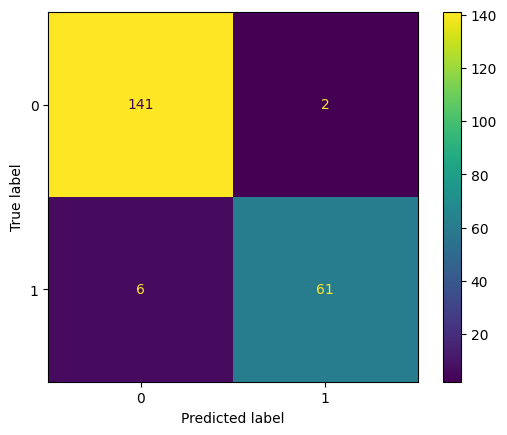

In [16]:
cm = confusion_matrix(y_test, y_pred_lr, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

disp.plot()

In [17]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

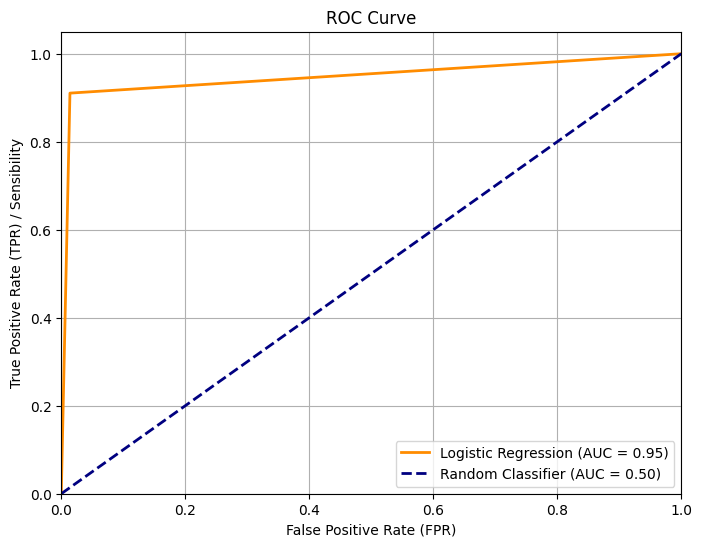


AUROC Score: 0.95


In [18]:
# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Sensibility')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAUROC Score: {roc_auc_lr:.2f}")

In [19]:
# get coefficients (for an interpretable equation)
# first, we neeed to extract the LogisticRegression model from our pipeline
lr_model = pipeline.named_steps['classifier']

# coefficients
coefficients_log = lr_model.coef_[0] # coef_ is an array of arrays for LogisticRegression

# intercept
intercept_log = lr_model.intercept_[0] # intercept_ is also an array 

# get feature names for interpretability 
feature_names = X_train.columns

print(f"\n--- LogisticRegression ---")
print(f"Intercept (b0): {intercept_log:.4f}")
print("Coefficients (bi):")
for name, coef in zip(feature_names, coefficients_log):
    print(f"  {name}: {coef:.4f}")

# create equation string for the linear part (Log-Odds)
equation_parts_log = [f"{intercept_log:.4f}"]
for name, coef in zip(feature_names, coefficients_log):
    sign = "+" if coef >= 0 else "-"
    equation_parts_log.append(f"{sign} {abs(coef):.4f} * {name}")

linear_combination = " + ".join(equation_parts_log)
linear_combination = linear_combination.replace("+ -", "-")
linear_combination = linear_combination.replace("+ +", "+")

print(f"\nLinear Combination (Log-Odds):\nZ = {linear_combination}")
print(f"Cancer Probability (P) = 1 / (1 + exp(-Z))")


--- LogisticRegression ---
Intercept (b0): -9.3348
Coefficients (bi):
  Clump Thickness: 0.5182
  Uniformity of Cell Size: -0.0462
  Uniformity of Cell Shape: 0.4283
  Marginal Adhesion: 0.1885
  Single Epithelial Cell Size: 0.0254
  Bare Nuclei: 0.4539
  Bland Chromatin: 0.4105
  Normal Nucleoli: 0.0525
  Mitoses: 0.3855

Linear Combination (Log-Odds):
Z = -9.3348 + 0.5182 * Clump Thickness - 0.0462 * Uniformity of Cell Size + 0.4283 * Uniformity of Cell Shape + 0.1885 * Marginal Adhesion + 0.0254 * Single Epithelial Cell Size + 0.4539 * Bare Nuclei + 0.4105 * Bland Chromatin + 0.0525 * Normal Nucleoli + 0.3855 * Mitoses
Cancer Probability (P) = 1 / (1 + exp(-Z))


In [20]:
# the LogisticRegression performed very well!
# now, we can save the model to use it in the future (with joblib)
joblib.dump(pipeline, '../model/logreg_breast_cancer_pipeline_v1.0.joblib')

['../model/logreg_breast_cancer_pipeline_v1.0.joblib']